In [2]:
################################################################################
# Libraries
################################################################################

import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import seaborn as sns

# Preprocesamiento
# from sklearn.preprocessing import Normalizer
# from sklearn.decomposition import PCA
from imblearn.under_sampling import EditedNearestNeighbours, TomekLinks, CondensedNearestNeighbour
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTENC

from sklearn.preprocessing import OneHotEncoder, LabelEncoder, KBinsDiscretizer
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif

In [4]:
################################################################################
# Load data
################################################################################

original_train = pd.read_csv("data/train_values.csv")
original_test  = pd.read_csv("data/test_values.csv")
original_labels = pd.read_csv("data/train_labels.csv")

train  = original_train
test   = original_test
labels = original_labels

# Columnas
for i,c in enumerate(train.columns):
    print(i, c)


0 building_id
1 geo_level_1_id
2 geo_level_2_id
3 geo_level_3_id
4 count_floors_pre_eq
5 age
6 area_percentage
7 height_percentage
8 land_surface_condition
9 foundation_type
10 roof_type
11 ground_floor_type
12 other_floor_type
13 position
14 plan_configuration
15 has_superstructure_adobe_mud
16 has_superstructure_mud_mortar_stone
17 has_superstructure_stone_flag
18 has_superstructure_cement_mortar_stone
19 has_superstructure_mud_mortar_brick
20 has_superstructure_cement_mortar_brick
21 has_superstructure_timber
22 has_superstructure_bamboo
23 has_superstructure_rc_non_engineered
24 has_superstructure_rc_engineered
25 has_superstructure_other
26 legal_ownership_status
27 count_families
28 has_secondary_use
29 has_secondary_use_agriculture
30 has_secondary_use_hotel
31 has_secondary_use_rental
32 has_secondary_use_institution
33 has_secondary_use_school
34 has_secondary_use_industry
35 has_secondary_use_health_post
36 has_secondary_use_gov_office
37 has_secondary_use_use_police
38 has_s

In [6]:
############################################################################
# No hay duplicados en los ids, se pueden quitar
############################################################################

train = train.drop(columns="building_id")
test = test.drop(columns="building_id")
labels = labels.drop(columns="building_id")

KeyError: "['building_id'] not found in axis"

In [ ]:
############################################################################
# Preprocesado Nº 2
# Quitar columnnas innecesarias / no interesantes
############################################################################

# Quitamos geo_2 y geo_3. Tienen demasiadas categorías diferentes para los árboles,
# y no se solapan
train = train.drop(columns=["geo_level_2_id","geo_level_3_id"])
test = test.drop(columns=["geo_level_2_id","geo_level_3_id"])


# En estas dos predomina (+85%) una clase y el resto no sirve para determinar
# ninguna etiqueta (se mantiene la proporción o las 3 están representadas)
train = train.drop(columns=["plan_configuration","legal_ownership_status"])
test = test.drop(columns=["plan_configuration","legal_ownership_status"])

# Altura y nº de plantas altamente correladas, categorizamos nº de plantas y quitamos altura
# Solo una instancia con 9 plantas, y las anteriores no siguen el mismo patrón (que todas sufrieran el mismo tipo de daño)
# Como tenemos proporciones muy similares, juntamos las +5 con ella
train["count_floors_pre_eq"] = train["count_floors_pre_eq"].replace({6:5, 7:5, 8:5, 9:5})
test["count_floors_pre_eq"] = test["count_floors_pre_eq"].replace({6:5, 7:5, 8:5, 9:5})

# No nos interesan variables numéricas en los árboles, acabarían discretizándose
train = train.drop(columns=["height_percentage"])
test = test.drop(columns=["height_percentage"])

train

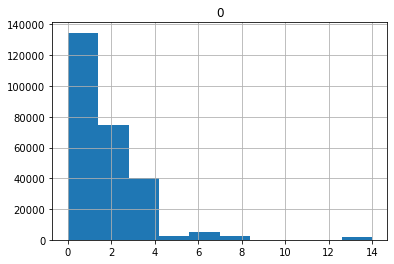

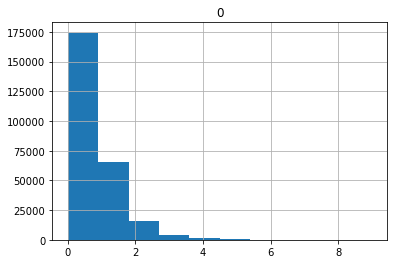

In [6]:
############################################################################
# v10 - Discretizar variables numéricas (age, area_percentage)
# count_families y count_floors considerarlas como categóricas
# Al final son age y area_percentage
# Age tiene años de 5 en 5 desde 0 hasta 200, más luego uno de 995, se podrían agrupar en 20
# Area percentage son porcentajes, se podría agrupar en intervalos de 10
# Los boxplot nos muestra una alta concentración en la parte baja con un gran
# número de puntos dispersos hacia arriba, se ve apropiado agruparlo mediante
# un método kmeans de manera que los puntos se asocien a una partición según
# el centroide más cercano
# 
# Los
############################################################################

disc = KBinsDiscretizer(n_bins=15, encode='ordinal', strategy='kmeans')
age = disc.fit_transform(train[["age"]])
age = pd.DataFrame(age)

test.age = pd.DataFrame(disc.transform(test[["age"]]))

disc = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='kmeans')
area = disc.fit_transform(train[["area_percentage"]])
area = pd.DataFrame(area)

test.area_percentage = pd.DataFrame(disc.transform(test[["area_percentage"]]))

age.hist()
area.hist()

train.age = age
train.area_percentage = area


In [6]:
############################################################################
# Eliminar instancias duplicadas
############################################################################

df = train.join(labels["damage_grade"])
df = df.drop_duplicates()

train = df.drop(columns=["damage_grade"])
labels = df["damage_grade"]

In [8]:
############################################################################
# One-hot-enconding
############################################################################

label_encoders = {}
# categorical_columns = ["geo_level_1_id",
#                         "land_surface_condition",
#                         "foundation_type",
#                         "roof_type",
#                         "ground_floor_type",
#                         "other_floor_type",
#                         "position",
#                        ]
# All
categorical_columns = train.columns

for column in categorical_columns:
    # Para training
    dummies = pd.get_dummies(train[column])
    dummies.columns = [column + "_" + str(x) for x in dummies.columns]
    train = train.drop(columns=column)
    train = pd.concat([train, dummies], axis=1)

    # Para test
    dummies = pd.get_dummies(test[column])
    dummies.columns = [column + "_" + str(x) for x in dummies.columns]
    test = test.drop(columns=column)
    test = pd.concat([test, dummies], axis=1)

train


,geo_level_1_id_0,geo_level_1_id_1,geo_level_1_id_2,geo_level_1_id_3,geo_level_1_id_4,geo_level_1_id_5,geo_level_1_id_6,geo_level_1_id_7,geo_level_1_id_8,geo_level_1_id_9,...,has_secondary_use_industry_0,has_secondary_use_industry_1,has_secondary_use_health_post_0,has_secondary_use_health_post_1,has_secondary_use_gov_office_0,has_secondary_use_gov_office_1,has_secondary_use_use_police_0,has_secondary_use_use_police_1,has_secondary_use_other_0,has_secondary_use_other_1
0,0,0,0,0,0,0,1,0,0,0,...,1,0,1,0,1,0,1,0,1,0
1,0,0,0,0,0,0,0,0,1,0,...,1,0,1,0,1,0,1,0,1,0
2,0,0,0,0,0,0,0,0,0,0,...,1,0,1,0,1,0,1,0,1,0
3,0,0,0,0,0,0,0,0,0,0,...,1,0,1,0,1,0,1,0,1,0
4,0,0,0,0,0,0,0,0,0,0,...,1,0,1,0,1,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260596,0,0,0,0,0,0,0,0,0,0,...,1,0,1,0,1,0,1,0,1,0
260597,0,0,0,0,0,0,0,0,0,0,...,1,0,1,0,1,0,1,0,1,0
260598,0,0,0,0,0,0,0,0,0,0,...,1,0,1,0,1,0,1,0,1,0
260599,0,0,0,0,0,0,0,0,0,0,...,1,0,1,0,1,0,1,0,1,0


In [13]:
for i,c in enumerate(train.columns):
    print(i, c)

0 geo_level_1_id
1 count_floors_pre_eq
2 age
3 area_percentage
4 land_surface_condition
5 foundation_type
6 roof_type
7 ground_floor_type
8 other_floor_type
9 position
10 has_superstructure_adobe_mud
11 has_superstructure_mud_mortar_stone
12 has_superstructure_stone_flag
13 has_superstructure_cement_mortar_stone
14 has_superstructure_mud_mortar_brick
15 has_superstructure_cement_mortar_brick
16 has_superstructure_timber
17 has_superstructure_bamboo
18 has_superstructure_rc_non_engineered
19 has_superstructure_rc_engineered
20 has_superstructure_other
21 count_families
22 has_secondary_use
23 has_secondary_use_agriculture
24 has_secondary_use_hotel
25 has_secondary_use_rental
26 has_secondary_use_institution
27 has_secondary_use_school
28 has_secondary_use_industry
29 has_secondary_use_health_post
30 has_secondary_use_gov_office
31 has_secondary_use_use_police
32 has_secondary_use_other


In [12]:
############################################################################
# v7 - SMOTE + ENN
# Oversampling de todas las clases inferiores, undersampling de puntos ruidosos
############################################################################

sme = SMOTEENN(random_state=42)
print('Original dataset shape %s' % len(labels))
X_res, y_res = sme.fit_resample(train, labels)
print('Resampled dataset shape %s' % len(y_res))

train = pd.DataFrame(X_res)
labels = pd.DataFrame(y_res)

labels.value_counts()


Original dataset shape 179275
Resampled dataset shape 125377


In [9]:
############################################################################
# v8y9 - SMOTE
############################################################################

# v8 Con onehot
# categorical = list(range(0,len(train.columns)))
# categorical.remove(14)
# categorical = categorical[3:]

# v9 SIN ONEHOT
categorical = list(range(0,len(train.columns)))
categorical.remove(1)
categorical.remove(2)
categorical.remove(3)
categorical.remove(21)

sm_nc = SMOTENC(categorical_features=categorical, random_state=0)
print('Original dataset shape %s' % len(labels))
x_smnc, y_smnc = sm_nc.fit_resample(train, labels)
print('Resampled dataset shape %s' % len(y_smnc))

train = pd.DataFrame(x_smnc)
labels = pd.DataFrame(y_smnc)

labels.value_counts()

Original dataset shape 179275
Resampled dataset shape 302703


Index(['geo_level_1_id_1', 'geo_level_1_id_3', 'geo_level_1_id_6',
       'geo_level_1_id_8', 'geo_level_1_id_11', 'geo_level_1_id_17',
       'geo_level_1_id_18', 'geo_level_1_id_20', 'geo_level_1_id_21',
       'geo_level_1_id_26', 'geo_level_1_id_27', 'count_floors_pre_eq_1',
       'count_floors_pre_eq_2', 'count_floors_pre_eq_3', 'age_0.0', 'age_2.0',
       'age_3.0', 'age_6.0', 'age_7.0', 'age_12.0', 'age_14.0',
       'area_percentage_0.0', 'land_surface_condition_t', 'foundation_type_h',
       'foundation_type_i', 'foundation_type_r', 'foundation_type_u',
       'foundation_type_w', 'roof_type_n', 'roof_type_q', 'roof_type_x',
       'ground_floor_type_f', 'ground_floor_type_v', 'other_floor_type_j',
       'other_floor_type_q', 'other_floor_type_s', 'other_floor_type_x',
       'position_o', 'position_s', 'has_superstructure_adobe_mud_0',
       'has_superstructure_adobe_mud_1',
       'has_superstructure_mud_mortar_stone_0',
       'has_superstructure_mud_mortar_stone_1',
 

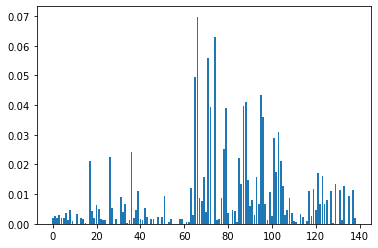

array([[0, 0, 1, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       ...,
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1]], dtype=uint8)

In [9]:
############################################################################
# Preprocesado 3.1
# Selección de características
# For classification: chi2, f_classif, mutual_info_classif
############################################################################

# selector = SelectKBest(chi2, k=15)
selector = SelectKBest(mutual_info_classif, k=80)
selector.fit(train, labels)
x_reduced = selector.transform(train)

# Ver columnas
columns = train.columns[selector.get_support()]
print(columns)

# test['count_families_9'] = 0

# Select same feautures as with train
tst_reduced = selector.transform(test)
test = pd.DataFrame(tst_reduced, columns=columns)
train = pd.DataFrame(x_reduced, columns=columns)

# Mostrar scores
# pd.DataFrame(selector.scores_).transpose()
plt.bar([i for i in range(len(selector.scores_))], selector.scores_)
plt.show()

x_reduced

In [9]:
############################################################################
# Preprocesado 3.1 ... continuación
# Aplicar undersampling
############################################################################

undersample = TomekLinks()
# undersample = CondensedNearestNeighbour(n_neighbors=1)
# undersample = EditedNearestNeighbours(n_neighbors=3)

# transform the dataset
X, y = undersample.fit_resample(train, labels)

print("Antes: " + str(len(train)))
print("Después: " + str(len(X)))

train = pd.DataFrame(X, columns=train.columns)
labels = y

In [8]:
################################################################################
# v1 Juntar columnas binarias
################################################################################

# Join has_superstructure (binary) columns has strings
# Get selected rows to string
df = train.iloc[:,15:25].astype(str)
df_test = test.iloc[:,15:25].astype(str)

# Join them
train["has_superstructure"] = df.apply(lambda x: ''.join(x), axis=1)
test["has_superstructure"] = df_test.apply(lambda x: ''.join(x), axis=1)

# Join has_secondary (binary) columns has strings
# Get selected rows to string
df = train.iloc[:,29:38].astype(str)
df_test = test.iloc[:,29:38].astype(str)

# Join them
train["has_secondary"] = df.apply(lambda x: ''.join(x), axis=1)
test["has_secondary"] = df_test.apply(lambda x: ''.join(x), axis=1)

# Remove joined columns
removed_cols = list(range(15,26)) + list(range(29,39))
train = train.drop(columns=train.columns[removed_cols])
test = test.drop(columns=test.columns[removed_cols])

# Convert new cols to int
# train["has_superstructure"] = train["has_superstructure"].apply(lambda x: int(x,2))
# train["has_secondary"] = train["has_secondary"].apply(lambda x: int(x,2))
# train

# Convert to categorical in order
# train.has_secondary = train.has_secondary.astype("category").cat.codes
# train.has_superstructure = train.has_superstructure.astype('category').cat.codes

# has_secondary_use is enconded in has_secondary, remove it
train = train.drop(columns="has_secondary_use")
test = test.drop(columns="has_secondary_use")
train

In [11]:
train

,geo_level_1_id_1,geo_level_1_id_3,geo_level_1_id_6,geo_level_1_id_8,geo_level_1_id_11,geo_level_1_id_17,geo_level_1_id_18,geo_level_1_id_20,geo_level_1_id_21,geo_level_1_id_26,...,has_secondary_use_hotel_1,has_secondary_use_rental_0,has_secondary_use_rental_1,has_secondary_use_institution_0,has_secondary_use_school_0,has_secondary_use_industry_0,has_secondary_use_health_post_0,has_secondary_use_gov_office_0,has_secondary_use_use_police_0,has_secondary_use_other_0
0,0,0,1,0,0,0,0,0,0,0,...,0,1,0,1,1,1,1,1,1,1
1,0,0,0,1,0,0,0,0,0,0,...,0,1,0,1,1,1,1,1,1,1
2,0,0,0,0,0,0,0,0,1,0,...,0,1,0,1,1,1,1,1,1,1
3,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,1,1,1,1,1,1
4,0,0,0,0,1,0,0,0,0,0,...,0,1,0,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108606,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,1,1,1,1,1,1
108607,0,0,0,0,0,0,0,1,0,0,...,0,1,0,1,1,1,1,1,1,1
108608,0,0,0,0,0,0,0,1,0,0,...,0,1,0,1,1,1,1,1,1,1
108609,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,1,1,1,1,1,1


In [12]:
################################################################################
# Write data
################################################################################
train.to_csv("data/v12 - preprocessed_train.csv", index=False)
labels.to_csv("data/v12 - preprocessed_train_labels.csv", index=False)
test.to_csv("data/v12 - preprocessed_test.csv", index=False)